In [0]:
import numpy as np
import os

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.optimizers import Adam
import keras as keras

import re
import itertools
from collections import Counter

import tensorflow as tf

np.random.seed(0)

In [0]:
def clean_Up(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data():
    # Load data from files
    positive_examples = list(open("/rt-polarity.pos", encoding='latin-1').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open("/rt-polarity.neg", encoding='latin-1').readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_Up(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def pad_sentences(sentences, padding_word="<PAD/>"):
    # pad sentences to the longest sentence's size
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(0,len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences


def build_vocab(sentences):
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]


def build_input_data(sentences, labels, vocabulary):
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]


def load_preprocess_data():
    # Load and preprocess data
    sentences, labels = load_data()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    return [x, y, vocabulary, vocabulary_inv]


def batch_iter(data, batch_size, num_epochs):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data) / batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffle_indices]
        for batch_num in range(0,num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [0]:
# Model Hyperparameters
embedding_dim = 50
filter_sizes = (3,4,5)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 50
num_epochs = 50

# Prepossessing parameters
sequence_length = 400
max_words = 5000

In [0]:
def process_data():
    x, y, vocabulary, vocabulary_inv_list = load_preprocess_data()
    vocabulary_inv = {key: value for key, value in enumerate(vocabulary_inv_list)}
    y = y.argmax(axis=1)

    # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x = x[shuffle_indices]
    y = y[shuffle_indices]
    train_len = int(len(x) * 0.9)
    x_train = x[:train_len]
    y_train = y[:train_len]
    x_test = x[train_len:]
    y_test = y[train_len:]

    return x_train, y_train, x_test, y_test, vocabulary_inv

In [22]:
# Data Preparation
print("Load data...")
x_train, y_train, x_test, y_test, vocabulary_inv = process_data()

if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

embedding_weights = None

Load data...
Adjusting sequence length for actual size
x_train shape: (9595, 56)
x_test shape: (1067, 56)
Vocabulary Size: 18765


In [0]:
input_shape = (sequence_length,)

model_input = Input(shape=input_shape)

z = Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)


In [0]:
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

step = tf.Variable(0, trainable=False)
# rate = tf.train.exponential_decay(0.001, step, 100000, 0.01) # tuning for learning rate, decay
opt = keras.optimizers.Adam(lr=0.01,decay=0.055)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [25]:
# Train the model
import time
start=time.time()
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)
print("Modified CNN-rand runtime: ", time.time()-start)

Train on 9595 samples, validate on 1067 samples
Epoch 1/50
 - 7s - loss: 0.6951 - acc: 0.5096 - val_loss: 0.6923 - val_acc: 0.5623
Epoch 2/50
 - 6s - loss: 0.6872 - acc: 0.5448 - val_loss: 0.6832 - val_acc: 0.6401
Epoch 3/50
 - 6s - loss: 0.6695 - acc: 0.5933 - val_loss: 0.6538 - val_acc: 0.6973
Epoch 4/50
 - 6s - loss: 0.6364 - acc: 0.6464 - val_loss: 0.6105 - val_acc: 0.7095
Epoch 5/50
 - 6s - loss: 0.5896 - acc: 0.6938 - val_loss: 0.5696 - val_acc: 0.7413
Epoch 6/50
 - 6s - loss: 0.5348 - acc: 0.7393 - val_loss: 0.5389 - val_acc: 0.7498
Epoch 7/50
 - 6s - loss: 0.5010 - acc: 0.7624 - val_loss: 0.5209 - val_acc: 0.7619
Epoch 8/50
 - 6s - loss: 0.4698 - acc: 0.7789 - val_loss: 0.5095 - val_acc: 0.7685
Epoch 9/50
 - 6s - loss: 0.4478 - acc: 0.7958 - val_loss: 0.5032 - val_acc: 0.7666
Epoch 10/50
 - 6s - loss: 0.4248 - acc: 0.8076 - val_loss: 0.4978 - val_acc: 0.7835
Epoch 11/50
 - 6s - loss: 0.3937 - acc: 0.8269 - val_loss: 0.4940 - val_acc: 0.7826
Epoch 12/50
 - 6s - loss: 0.3895 - ac

In [0]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']

In [0]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']

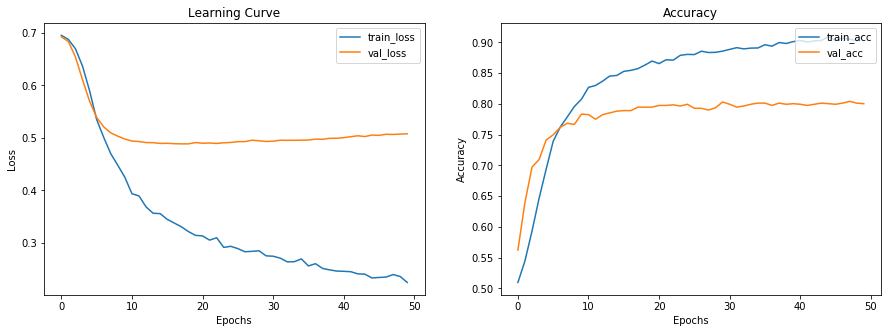

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_acc,label="train_acc")
plt.plot(val_acc,label="val_acc")
plt.legend(loc=1)

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes='true')